In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import calib_camera
from calib_camera import find_obj_and_img_points, calibrate_camera
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

#### Step 1: Camera Calibration

In [1]:
# calib_camera.logger.setLevel("DEBUG")

In [3]:
nx = 9
ny = 6
images = glob.glob("camera_cal/calibration*.jpg")
pickle_file = "camera_cal/dist_pickle.p"

In [4]:
# Find object and image points and use these to calibrate the camera
objpoints, imgpoints = find_obj_and_img_points(images, nx, ny)
mtx, dist = calibrate_camera(objpoints, imgpoints, (1280, 720))

# save required variables in a pickle file
dict_pickle = dict(objpoints=objpoints, imgpoints=imgpoints, mtx=mtx, dist=dist)
pickle.dump(dict_pickle, open(pickle_file, "wb"))

2019-09-28 14:43:36,701 - CalibCamera - INFO - Found corners on 17 images
2019-09-28 14:43:37,506 - CalibCamera - INFO - Returned mtx and dist from camera calibration


#### Step 2: Undistort and transform perspective

Let's use one image as an example and transform that into a bird-eye view

In [3]:
from pipeline import perspective_transform

test2.jpg


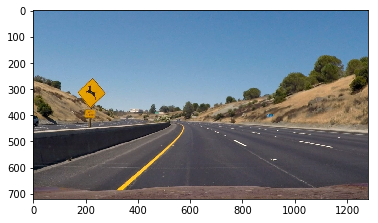

In [4]:
fnames = os.listdir("test_images")
idx = 5
fname = fnames[idx]
print(fname)
img = cv2.imread(os.path.join("test_images", fname))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [8]:
# first load mtx and dist
pickle_file = "camera_cal/dist_pickle.p"
dict_pickle = pickle.load(open(pickle_file, "rb"))
mtx, dist = dict_pickle["mtx"], dict_pickle["dist"]

In [159]:
src = np.float32(
      [[ 585,  460],
       [ 203,  720],
       [1126,  720],
       [ 695,  460]])

dst = np.float32(
      [[350,   0.],
       [350, 720.],
       [950, 720.],
       [950,   0.]])

In [160]:
warped_img, M = perspective_transform(img, mtx, dist, src, dst, img_size=(img.shape[1], img.shape[0]))

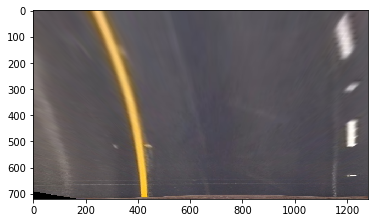

In [158]:
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))  # seems plausible

In [ ]:
# Testing undistort

# images = glob.glob('camera_cal/calibration*.jpg')
# idx = 1
# fname = images[idx]
# print(fname)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# img = cv2.imread(fname)
# dst = cv2.undistort(img, mtx, dist, None, mtx)
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=20)
# ax2.imshow(dst)
# ax2.set_title("Undistorted Image", fontsize=20)

#### Step 3: Color Thresholding

In [74]:
from pipeline import abs_sobel_thresh, dir_thresh, mag_thresh, hls_thresh, rgb_thresh, luv_thresh

In [75]:
grad_binary = abs_sobel_thresh(warped_img, orient='x', thresh=(20, 100), sobel_kernel=3)
mag_binary = mag_thresh(warped_img, thresh=(30, 100), sobel_kernel=3)
dir_binary = dir_thresh(warped_img, thresh=(0.7, 1.3), sobel_kernel=15)
hls_binary = hls_thresh(warped_img, hls_channel="S", thresh=(90, 255))
assert grad_binary.shape == mag_binary.shape == dir_binary.shape == hls_binary.shape == warped_img.shape[:2] 

In [77]:
l_binary = hls_thresh(warped_img, hls_channel="L", thresh=(30, 100))
r_binary = rgb_thresh(warped_img, rgb_channel="R", thresh=(200, 255))
luv_l_binary = luv_thresh(warped_img, luv_channel="l", thresh=(225, 255))

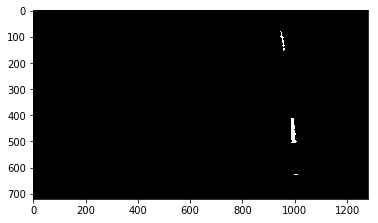

In [79]:
plt.imshow(luv_l_binary, cmap="gray")

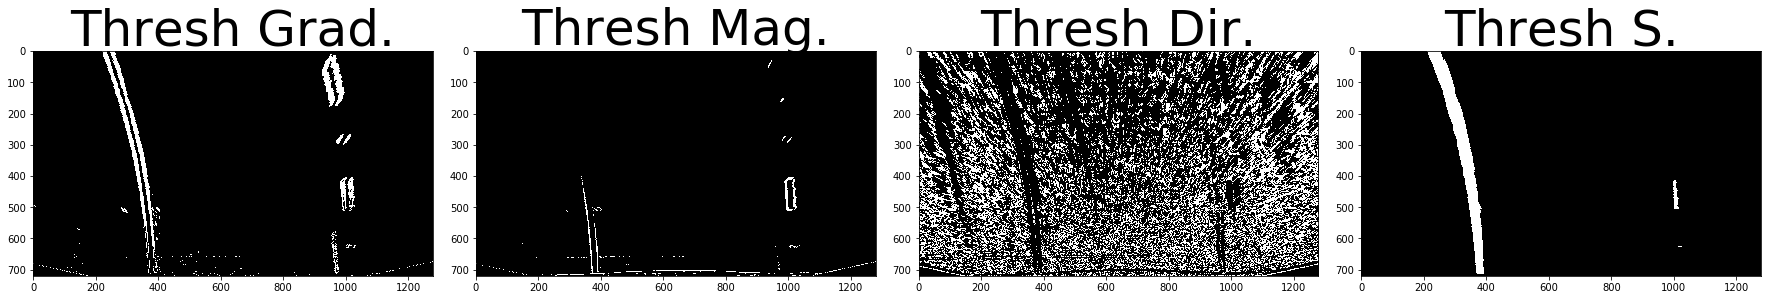

In [12]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(grad_binary, cmap="gray")
ax1.set_title('Thresh Grad.', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresh Mag.', fontsize=50)
ax3.imshow(dir_binary, cmap='gray')
ax3.set_title('Thresh Dir.', fontsize=50)
ax4.imshow(hls_binary, cmap='gray')
ax4.set_title('Thresh S.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [87]:
# Combine thresholds
combined_binary = np.zeros_like(dir_binary)
# combined_binary[((hls_binary == 1) & (l_binary==0)) | (r_binary==1) | ((grad_binary == 1) | ((mag_binary == 1) & (dir_binary == 0)))] = 1
# combined_binary[(hls_binary == 1) | ((grad_binary == 1) | ((mag_binary == 1) & (dir_binary == 0)))] = 1
# combined_binary[(hls_binary == 1) | (mag_binary == 1)] = 1
# combined_binary[(hls_binary == 1) | ( ((mag_binary == 1) & (dir_binary == 0)))] = 1
combined_binary[((hls_binary == 1) | (luv_l_binary==1))] = 1

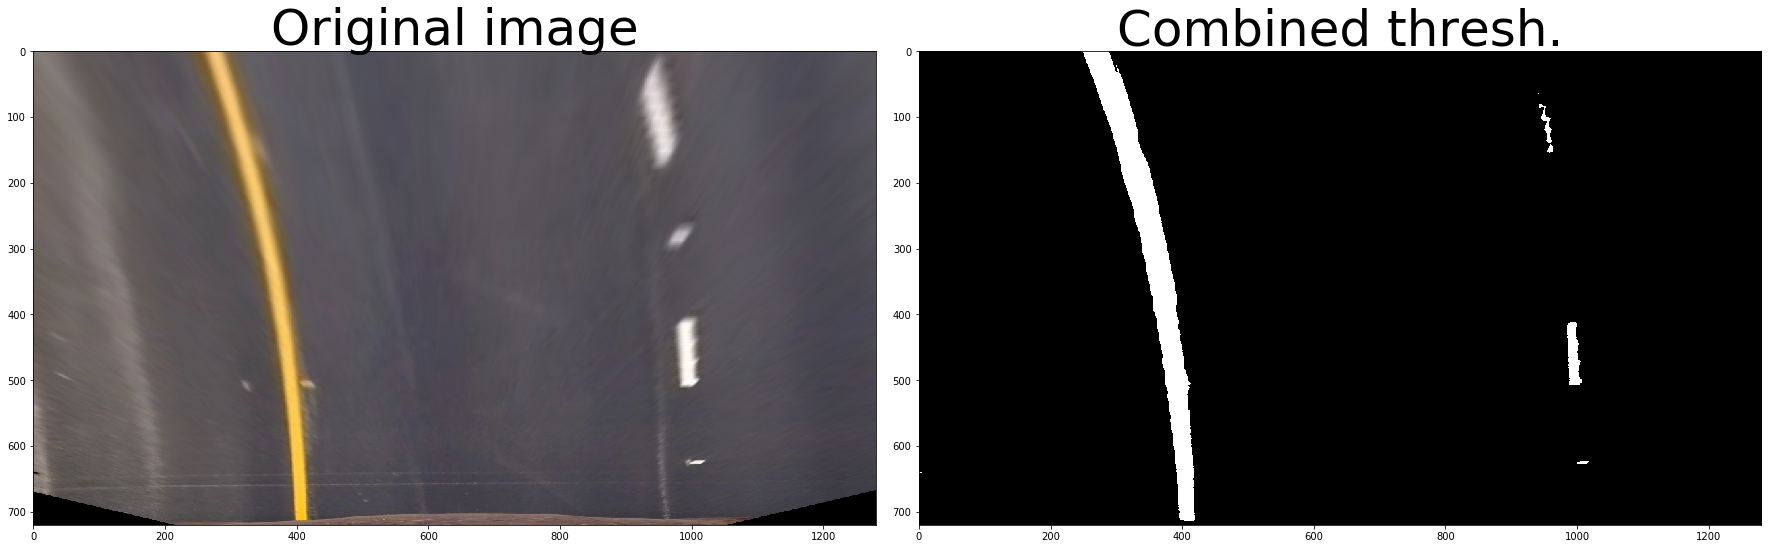

In [88]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined thresh.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Step 4: Find lane lines

In [15]:
def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')

In [16]:
from pipeline import hist, search_around_poly, fit_poly, fit_polynomial

In [17]:
def find_lanes_from_scratch(binary_warped, nwindows=9, margin=100, minpix=50, draw_lanes=True):
    """ Detects lane pixels from scratch """
    histogram = hist(binary_warped)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) # create output image to draw on (not necessary)
    midpoint = np.int(histogram.shape[0]//2)  # 640
    leftx_base = np.argmax(histogram[:midpoint])  # find index of left peak (indicates ll)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint # find index of right peak (indicates rl)
    
    window_height = np.int(binary_warped.shape[0]//nwindows)  # 80
    nonzero = binary_warped.nonzero()  # a tuple for x and y
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):  # index 0 to 8
        win_y_low = binary_warped.shape[0] - (window+1)*window_height  
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if draw_lanes:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) # bottom left to top right, in green, with thickness 2
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & 
                (nonzeroy >= win_y_low ) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & 
            (nonzeroy >= win_y_low ) & (nonzeroy < win_y_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)  # indices
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
            # print(leftx_current)
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, deg=2)
    right_fit = np.polyfit(righty, rightx, deg=2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    detected_flag = True
    
    if draw_lanes:
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        for index in range(out_img.shape[0]-1):
            cv2.line(out_img, (int(left_fitx[index]), int(ploty[index])), (int(left_fitx[index+1]), int(ploty[index+1])), (255,255,0), 3)
            cv2.line(out_img, (int(right_fitx[index]), int(ploty[index])), (int(right_fitx[index+1]), int(ploty[index+1])), (255,255,0), 3)
    return left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag

In [18]:
left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag = find_lanes_from_scratch(combined_binary, draw_lanes=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


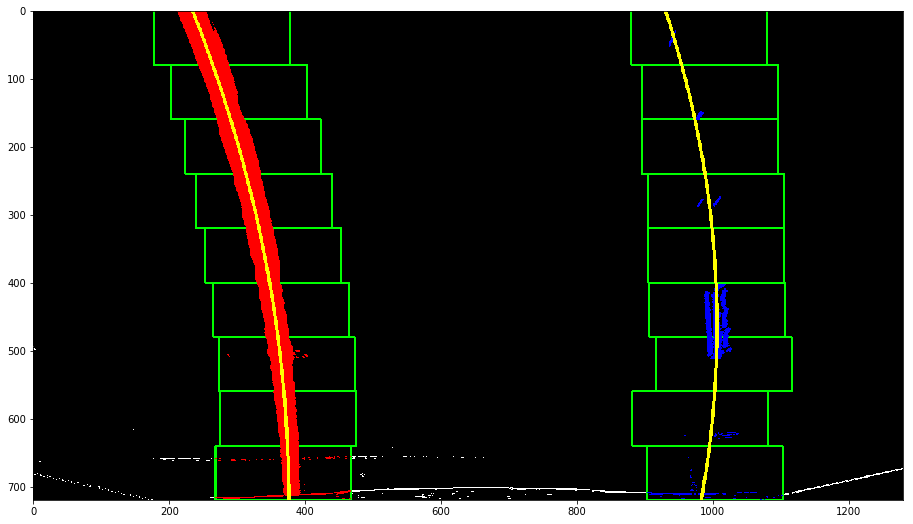

In [16]:
plt.figure(figsize=(24, 9))
plt.imshow(out_img)

In [19]:
def find_lanes_from_prior(binary_warped, left_fit, right_fit, margin=100, draw_lanes=True):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox >= left_fit[0]*nonzeroy**2 + 
        left_fit[1]*nonzeroy + left_fit[2] - margin) & 
        (nonzerox < left_fit[0]*nonzeroy**2 + 
        left_fit[1]*nonzeroy + left_fit[2] + margin)).nonzero()[0]
    right_lane_inds = ((nonzerox >= right_fit[0]*nonzeroy**2 + 
        right_fit[1]*nonzeroy + right_fit[2] - margin) & 
        (nonzerox < right_fit[0]*nonzeroy**2 + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)).nonzero()[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    if leftx.size == 0 or rightx.size == 0:
        detected_flag = False
        return None, None, None, None, None, out_img, False  # super ugly
    else:
        detected_flag = True

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    if draw_lanes:
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        for index in range(out_img.shape[0]-1):
            cv2.line(out_img, (int(left_fitx[index]), int(ploty[index])), (int(left_fitx[index+1]), int(ploty[index+1])), (255,255,0), 3)
            cv2.line(out_img, (int(right_fitx[index]), int(ploty[index])), (int(right_fitx[index+1]), int(ploty[index+1])), (255,255,0), 3)
    
    return left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag

In [20]:
left_fitx, right_fitx, _, _, ploty, out_img, detected_flag = find_lanes_from_prior(combined_binary, left_fit, right_fit)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


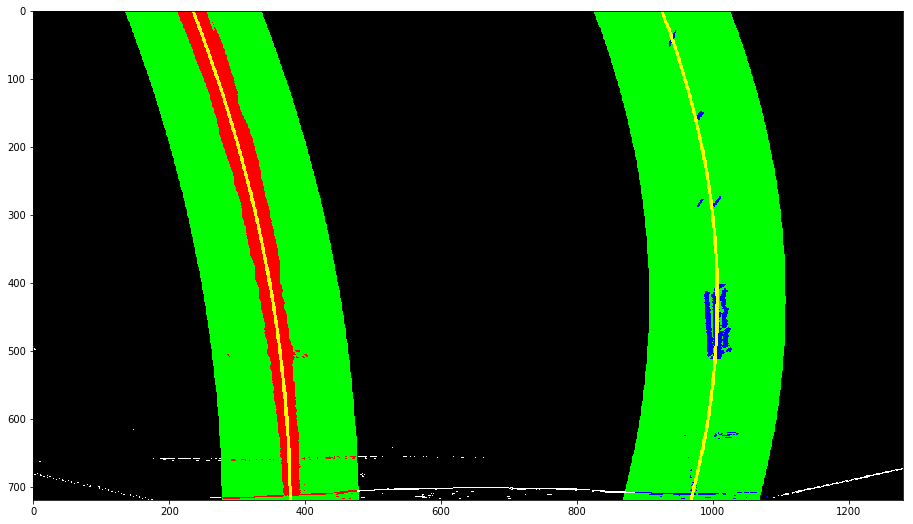

In [133]:
plt.figure(figsize=(24,9))
plt.imshow(out_img)

#### 5a. Measure curvature


In [21]:
def measure_curvature(ploty, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fitx = left_fitx[::-1]
    right_fitx = right_fitx[::-1]
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**(3/2)/(2*np.abs(left_fit_cr[0]))  ## Implement the calculation of the left line here
    right_curverad = (1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**(3/2)/(2*np.abs(right_fit_cr[0]))  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

In [21]:
left_curverad, right_curverad = measure_curvature(ploty, left_fitx, right_fitx)

In [28]:
print(f"left curve radius: {left_curverad}m, right curve radius: {right_curverad}m")

left curve radius: 632.1965056261458m, right curve radius: 363.87041745863485m


#### 5b. Determine offset from center

In [22]:
def measure_offset(left_fitx, right_fitx, midpoint=640):
    return (midpoint-(right_fitx[-1]+left_fitx[-1])/2)*3.7/700

In [23]:
offset = measure_offset(left_fitx, right_fitx, midpoint=out_img.shape[1]//2)
print(f"Offset is {offset}m")

Offset is -0.17547198318720966m


#### 6. Warp back to original image with curvature and offset text

In [23]:
def warp_back(out_img, orig_img, combined_binary, dst, src, left_fitx, right_fitx, ploty):
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (orig_img.shape[1], orig_img.shape[0])) 

    img_with_lane = cv2.addWeighted(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB), 1, newwarp, 0.3, 0)
    return img_with_lane
    

In [188]:
img_with_lane = warp_back(out_img, img, combined_binary, dst, src, left_fitx, right_fitx, ploty)

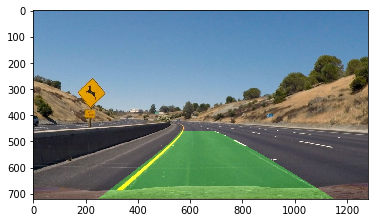

In [189]:
plt.imshow(img_with_lane)

#### 6b. Print curvatures and offset from center onto image

In [24]:
def show_crv_and_offset(img_with_lane, left_curverad, right_curverad, offset):
    img_with_lane = cv2.putText(img_with_lane, 'Left lane curvature: {:.2f} m'.format(left_curverad), 
                    (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    img_with_lane = cv2.putText(img_with_lane, 'Right lane curvature: {:.2f} m'.format(right_curverad), 
                    (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    # Display car offset
    img_with_lane = cv2.putText(img_with_lane, 'Offset: {:.2f} m'.format(offset), 
                    (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    return img_with_lane

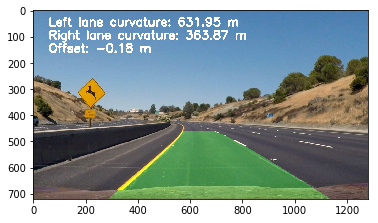

In [27]:
img_with_lane = show_crv_and_offset(img_with_lane, left_curverad, right_curverad, offset)
plt.imshow(img_with_lane)

### Test on video

Define class which stores attributes across frames

In [28]:
import imageio
imageio.plugins.ffmpeg.download()

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [138]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        # self.current_fit = [np.array([False])]  
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.not_found_counter = 0
        self.initial_scratch_search = True
        self.continuous_frames_with_no_lanes = 5
        self.frame_counter = 0
        self.frame_buffer = 12
        self.lane_margin = None  # ToDo: set this
        # ToDo: some attributes should be properties
        # ToDo: set the other attributes as well
        # ToDo: add frame_counter to count all frames (to know how many frames per second)  # 24 frames per second

In [106]:
# search from scratch always has to find something
# search from prior does not necessarily have to find something

# search from scratch: first frame of video or when nothing has been found from priors

# could be that leftx, lefty ... have to be passed out of the function as well!

In [107]:
def append_or_replace(l_list, index, item, list_len=5):
    if len(l_list)<list_len:
        l_list.append(item)
    else:
        l_list[index] = item
    assert len(l_list)<=list_len

In [161]:
def process_image(image):
    warped_img, M = perspective_transform(image, mtx, dist, src, dst, img_size=(image.shape[1], image.shape[0]))
    
    grad_binary = abs_sobel_thresh(warped_img, orient='x', thresh=(20, 100), sobel_kernel=3)
    mag_binary = mag_thresh(warped_img, thresh=(30, 100), sobel_kernel=3)
    dir_binary = dir_thresh(warped_img, thresh=(0.7, 1.3), sobel_kernel=15)
    s_binary = hls_thresh(warped_img, hls_channel="S", thresh=(90, 255))
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(grad_binary == 1) | (s_binary == 1) | ( ((mag_binary == 1) & (dir_binary == 0)))] = 1
    # combined_binary[(s_binary == 1) | (r_binary == 1) | ((mag_binary == 1) & (dir_binary == 0))] = 1  # the r and luv_l channel are not robust to changing conditions!
    
    
    # Enforce search from scratch on frame 0
    if leftlane.initial_scratch_search or rightlane.initial_scratch_search:
        left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag = find_lanes_from_scratch(combined_binary)
        leftlane.detected, rightlane.detected = True, True
        leftlane.current_fit, rightlane.current_fit = left_fit, right_fit
        leftlane.initial_scratch_search, rightlane.initial_scratch_search = False, False
        # leftlane.recent_xfitted.append(left_fitx), rightlane.recent_xfitted.append(right_fitx)
        
    if not leftlane.detected or not rightlane.detected:  # if no lane detected for 30 frames, search from scratch (technically better to separate left and right lanes)
        leftlane.not_found_counter += 1
        rightlane.not_found_counter += 1
        if leftlane.not_found_counter < leftlane.continuous_frames_with_no_lanes:
            result = show_crv_and_offset(image, leftlane.radius_of_curvature, rightlane.radius_of_curvature, leftlane.line_base_pos)
            return result
        else:
            print(f"nothing lanes for {leftlane.continuous_frames_with_no_lanes} frames... search from scratch")
            left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag = find_lanes_from_scratch(combined_binary)
            leftlane.detected, rightlane.detected = True, True
            leftlane.current_fit, rightlane.current_fit = left_fit, right_fit
            leftlane.not_found_counter, rightlane.not_found_counter = 0, 0  # reset counter
    else:  # if lanes detected previously, search from prior
        left_fitx, right_fitx, leftlane.current_fit, rightlane.current_fit, ploty, out_img, detected_flag = find_lanes_from_prior(combined_binary, leftlane.current_fit, rightlane.current_fit, margin=100)
        leftlane.detected = detected_flag  
        rightlane.detected = detected_flag
        leftlane.not_found_counter, rightlane.not_found_counter = 0, 0  # reset counter
        # leftlane.recent_xfitted.append(left_fitx), rightlane.recent_xfitted.append(right_fitx)
        
    append_or_replace(leftlane.recent_xfitted, leftlane.frame_counter%leftlane.frame_buffer, left_fitx, list_len=leftlane.frame_buffer)
    append_or_replace(rightlane.recent_xfitted, rightlane.frame_counter%rightlane.frame_buffer, right_fitx, list_len=rightlane.frame_buffer)
    try:  # to avoid a bad start (might happen when margin is set too small)
        left_fitx = np.median(np.array([x for x in leftlane.recent_xfitted if x is not None]), axis=0)  # using median because more robust against outliers
        right_fitx = np.median(np.array([x for x in rightlane.recent_xfitted if x is not None]), axis=0)
    except:
        print("cannot take the median")
        pass
    #left_fitx = np.median(np.array([x for x in leftlane.recent_xfitted if x is not None]), axis=0)
    #right_fitx = np.median(np.array([x for x in rightlane.recent_xfitted if x is not None]), axis=0)
    
    try:
        left_curverad, right_curverad = measure_curvature(ploty, left_fitx, right_fitx)
        offset = measure_offset(left_fitx, right_fitx, midpoint=out_img.shape[1]//2)
        leftlane.radius_of_curvature, rightlane.radius_of_curvature = left_curverad, right_curverad
        leftlane.line_base_pos, rightlane.line_base_pos = offset, offset
        img_with_lane = warp_back(out_img, image, combined_binary, dst, src, left_fitx, right_fitx, ploty)
        result = show_crv_and_offset(img_with_lane, leftlane.radius_of_curvature, rightlane.radius_of_curvature, leftlane.line_base_pos)
    except:
        result = show_crv_and_offset(image, leftlane.radius_of_curvature, rightlane.radius_of_curvature, leftlane.line_base_pos)
    
    leftlane.frame_counter+=1
    rightlane.frame_counter+=1
    
    if leftlane.frame_counter == leftlane.frame_buffer or rightlane.frame_counter == rightlane.frame_buffer:
        leftlane.frame_counter, rightlane.frame_counter = 0, 0
    
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

In [162]:
leftlane = Line()
rightlane = Line()
input_video = './harder_challenge_video.mp4'
output_video = './harder_challenge_video_result.mp4'
#output_video = './harder_challenge_video_solution.mp4'
## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False, progress_bar=False)

[MoviePy] >>>> Building video ./harder_challenge_video_result.mp4
[MoviePy] Writing video ./harder_challenge_video_result.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_video_result.mp4 

CPU times: user 3min 28s, sys: 55.3 s, total: 4min 23s
Wall time: 3min 32s


In [163]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))

- can enforce searching from scratch by setting a very small margin
- separate left and right searching (don't need to search frmo scratch for both)
- add sanity check if min of right_lane  is smaller than max of left line (meaning both intersect) -> or use smaller src, dst windows
- calculate lane width, if too large or negative: search from scratch
- return leftx, lefty etc. to fit poly on average of those
- if curvatures diverge too much (by factor of 10), mirror more plausible curvature on left/right lane; start point is on bottom of image (since those 
are detected most reliably)
- fit more complex polynomial (order=3 or more)
- making the road "skinnier" kind of works better

Unused Code

In [414]:
# lets do it step by step
binary_warped = combined_binary
histogram = hist(binary_warped) # sum over pixel values of bottom half image -> peaks indicate lines
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) # create output image to draw on (not necessary)
midpoint = np.int(histogram.shape[0]//2)  # 640
leftx_base = np.argmax(histogram[:midpoint])  # find index of left peak (indicates ll)
rightx_base = np.argmax(histogram[midpoint:]) + midpoint # find index of right peak (indicates rl)
nwindows = 9
margin = 100
minpix = 50
window_height = np.int(binary_warped.shape[0]//nwindows)  # 80
nonzero = binary_warped.nonzero()  # a tuple for x and y
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftx_current = leftx_base
rightx_current = rightx_base
left_lane_inds = []
right_lane_inds = []
for window in range(nwindows):  # index 0 to 8
    win_y_low = binary_warped.shape[0] - (window+1)*window_height  
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) # bottom left to top right, in green, with thickness 2
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & 
            (nonzeroy >= win_y_low ) & (nonzeroy < win_y_high)).nonzero()[0]
    good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & 
        (nonzeroy >= win_y_low ) & (nonzeroy < win_y_high)).nonzero()[0]
    left_lane_inds.append(good_left_inds)  # indices
    right_lane_inds.append(good_right_inds)
    if len(good_left_inds) > minpix:
        leftx_current = int(np.mean(nonzerox[good_left_inds]))
        # print(leftx_current)
    if len(good_right_inds) > minpix:
        rightx_current = int(np.mean(nonzerox[good_right_inds]))

left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

left_fit = np.polyfit(lefty, leftx, deg=2)
right_fit = np.polyfit(righty, rightx, deg=2)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
for index in range(binary_warped.shape[0]):
    cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
    cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))

In [ ]:
def process_image(image):
    warped_img, M = perspective_transform(image, mtx, dist, src, dst, img_size=(image.shape[1], image.shape[0]))
    
    mag_binary = mag_thresh(warped_img, thresh=(30, 100), sobel_kernel=3)
    dir_binary = dir_thresh(warped_img, thresh=(0.7, 1.3), sobel_kernel=15)
    hls_binary = hls_thresh(warped_img, hls_channel="S", thresh=(90, 255))
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(hls_binary == 1) | ( ((mag_binary == 1) & (dir_binary == 0)))] = 1
    
    if not leftlane.detected or not rightlane.detected:  # if no lane detected, search from scratch (technically better to separate left and right lanes)
        print("have to search from scratch")
        left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag = find_lanes_from_scratch(combined_binary)
        leftlane.current_fit, rightlane.current_fit = left_fit, right_fit
        leftlane.detected, rightlane.detected = True, True
        leftlane.search_from_scratch_counter += 1
        rightlane.search_from_scratch_counter += 1
    else:  # if lanes detected previously, search from prior
        left_fitx, right_fitx, leftlane.current_fit, rightlane.current_fit, ploty, out_img, detected_flag = find_lanes_from_prior(combined_binary, leftlane.current_fit, rightlane.current_fit, margin=10)
        leftlane.detected = detected_flag  
        rightlane.detected = detected_flag
    
    try:
        left_curverad, right_curverad = measure_curvature(ploty, left_fitx, right_fitx)
        offset = measure_offset(left_fitx, right_fitx, midpoint=out_img.shape[1]//2)
        leftlane.radius_of_curvature, rightlane.radius_of_curvature = left_curverad, right_curverad
        leftlane.line_base_pos, rightlane.line_base_pos = offset, offset
        img_with_lane = warp_back(out_img, image, combined_binary, dst, src, left_fitx, right_fitx, ploty)
        result = show_crv_and_offset(img_with_lane, leftlane.radius_of_curvature, rightlane.radius_of_curvature, leftlane.line_base_pos)
    except:
        result = show_crv_and_offset(image, leftlane.radius_of_curvature, rightlane.radius_of_curvature, leftlane.line_base_pos)
    
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

In [140]:
# warp to birds eye-view
src = np.float32([[490, 482],
                  [810, 482],  # 482
                  [1250, 720],
                  [40, 720]])
dst = np.float32([[0, 0], 
                  [1280, 0], 
                  [1250, 720],
                  [40, 720]])

In [107]:
src = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right

dst = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

In [6]:
# counter clockwise: top left, bottom left, bottom right, top right
src = np.float32(
      [[ 585,  460],
       [ 203,  720],
       [1126,  720],
       [ 695,  460]])

dst = np.float32(
      [[320,   0.],
       [320, 720.],
       [960, 720.],
       [960,   0.]])